In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [28]:
def out_to_csv(in_filename, out_filename):
    data = []
    i = -1
    with open(in_filename) as in_f:
        lines = in_f.readlines()
    for line in lines:
        if not isNumber(line):
            i += 1
            data.append([])
        else:
            data[i].append(int(line))
    with open(out_filename, 'w') as out_f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                if j == len(data[i])-1:
                    out_f.write("{}\n".format(data[i][j]))
                else:
                    out_f.write("{},".format(data[i][j]))
        
    
def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [3]:
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']

data_names = (
    ['totalTime{}Reana'.format(spl) for spl in spls]
    + ['totalTime{}ReanaE'.format(spl) for spl in spls])

print(data_names)

for data_name in data_names:
    out_to_csv('data/{}.out'.format(data_name), 'csv/{}.csv'.format(data_name))

[&#39;totalTimeBSNReana&#39;, &#39;totalTimeEmailReana&#39;, &#39;totalTimeICReana&#39;, &#39;totalTimeLiftReana&#39;, &#39;totalTimeMPReana&#39;, &#39;totalTimeTWReana&#39;, &#39;totalTimeBSNReanaE&#39;, &#39;totalTimeEmailReanaE&#39;, &#39;totalTimeICReanaE&#39;, &#39;totalTimeLiftReanaE&#39;, &#39;totalTimeMPReanaE&#39;, &#39;totalTimeTWReanaE&#39;]


In [29]:
def _read_data(spl):
    (fn1, fn2) = ['csv/totalTime{}{}.csv'.format(spl, t) for t in ['Reana', 'ReanaE']]
    
    df1 = pd.read_csv(fn1, header=None).transpose()
    df2 = pd.read_csv(fn2, header=None).transpose()
    
    n = min(df1.shape[0], df2.shape[0])
    # delete extra rows in one df (to match sample sizes)
    if df1.shape[0] > n:
        rows = list(range(n, df1.shape[0]))
        # print('Dropping rows {} from df1'.format(rows))
        df1 = df1.drop(rows)
    elif df2.shape[0] > n:
        rows = list(range(n, df2.shape[0]))
        # print('Dropping rows {} from df2'.format(rows))
        df2 = df2.drop(rows)
        
    df = pd.concat([df1, df2], keys=['reana', 'reanae'])
    df /= 1000.0
    
    return df, n

def read_data(spl):
    df, n = _read_data(spl)
    df['Type'] = np.repeat(['reana', 'reanaE'], [n, n], axis=0)
    return df

In [30]:
def make_line_graph(df, spl, yscale='linear', filename=None):
    reana_mean = np.mean(df.loc['reana'])
    reana_std = np.std(df.loc['reana'])
    reanae_mean = np.mean(df.loc['reanae'])
    reanae_std = np.std(df.loc['reanae'])
    
    df_mean = pd.concat([reana_mean, reanae_mean], keys=['reana', 'reanae'])
    
    plt.figure(figsize=(12,5))
    
    ax1 = df_mean['reana'].plot(grid=True, yerr=reana_std, label='Reana')
    ax2 = df_mean['reanae'].plot(grid=True, secondary_y=False, yerr=reanae_std, label='ReanaE')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()

    xticks = np.arange(0, df_mean['reanae'].shape[0], 1)
    ax1.set_xticks(xticks)
    ax2.set_xticks(xticks)

    # plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend()
    plt.yscale(yscale)
    plt.xlabel('Evolution')
    plt.ylabel('Running Time (s)')
    plt.title(spl)
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

In [42]:
def make_box_plot(df, spl, filename=None):
    means = np.mean(df)
    stdevs = np.std(df)
    fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
    
    i = 4
    j = 4
    while i * 5 + j + 1 > len(means):
        fig.delaxes(ax_new[i, j])
        if j == 0:
            j = 4
            i -= 1
        else:
            j -= 1

    bp = df.boxplot(by="Type",ax=ax_new.flatten()[:len(means)], figsize=(6,8))

    for i in range(len(means)):
        ax_new.flatten()[i].autoscale()
        ax_new.flatten()[i].set_xlabel('')
    
    fig.suptitle('{}: Reana vs ReanaE'.format(spl))
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

In [40]:
def get_extended_df(spl):
    df, _ = _read_data(spl)

    reana_means = np.mean(df.loc['reana'])
    reana_std = np.std(df.loc['reana'])

    reanae_means = np.mean(df.loc['reanae'])
    reanae_std = np.std(df.loc['reanae'])

    dfe = pd.DataFrame()
    dfe['means'] = pd.concat([reana_means, reanae_means], keys=['reana', 'reanae'])
    dfe['std'] = pd.concat([reana_std, reanae_std], keys=['reana', 'reanae'])
    return dfe

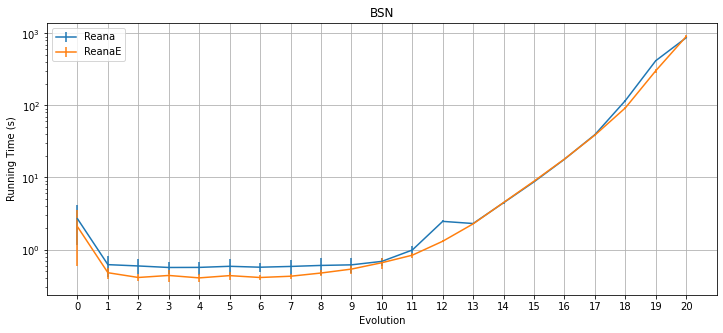

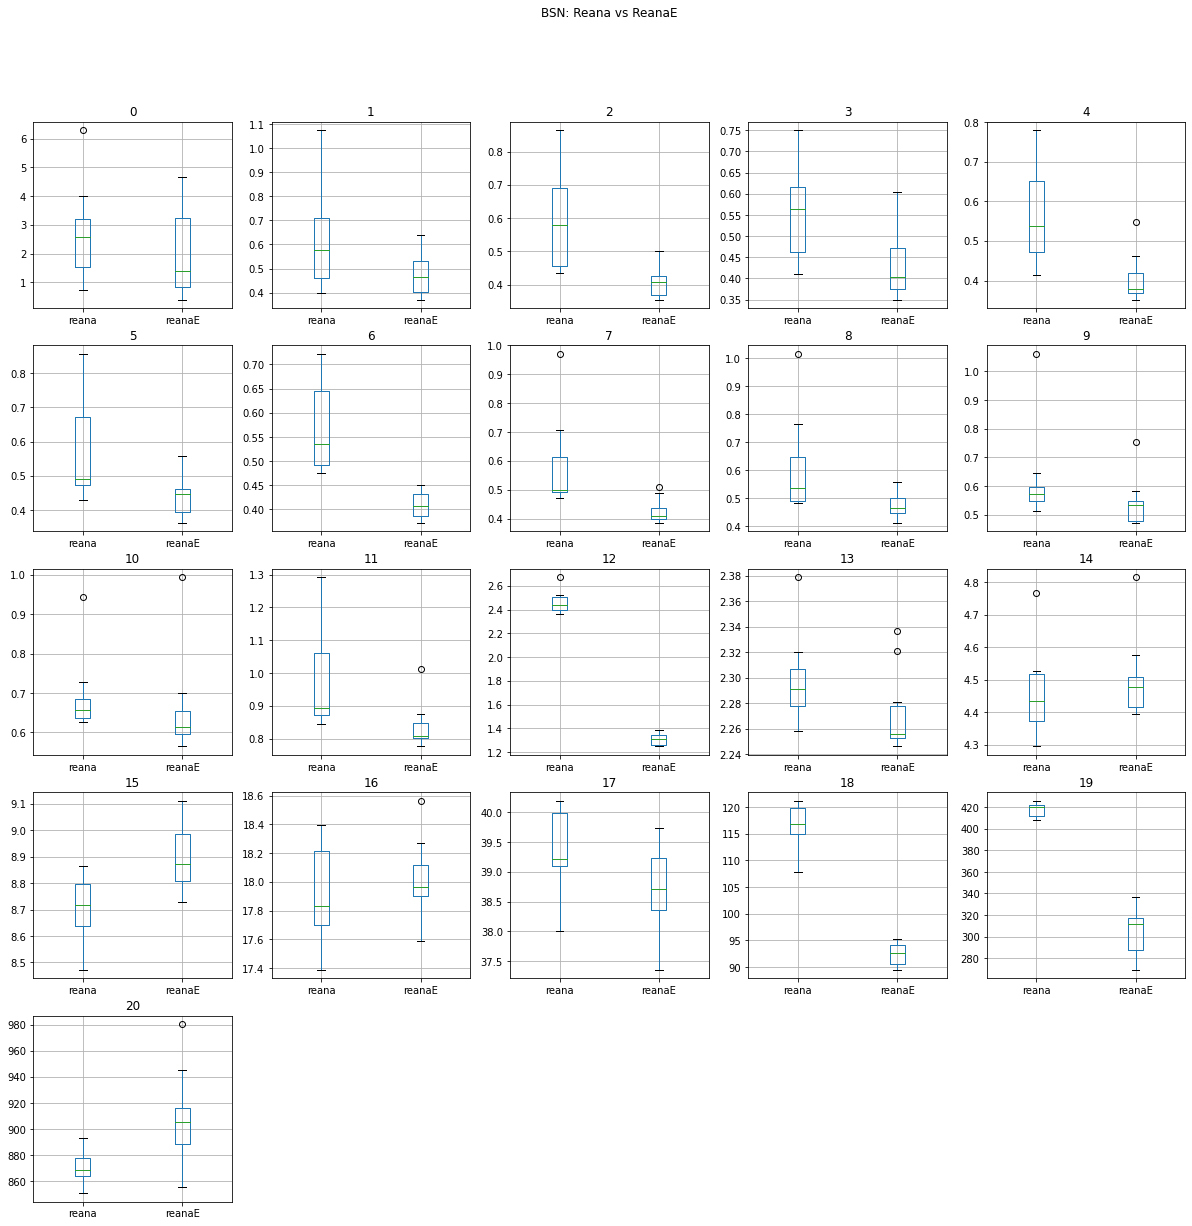

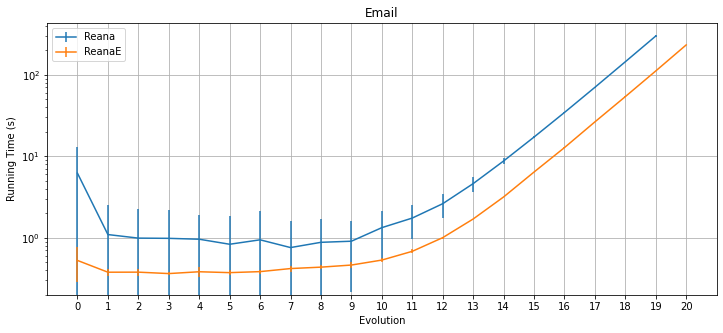

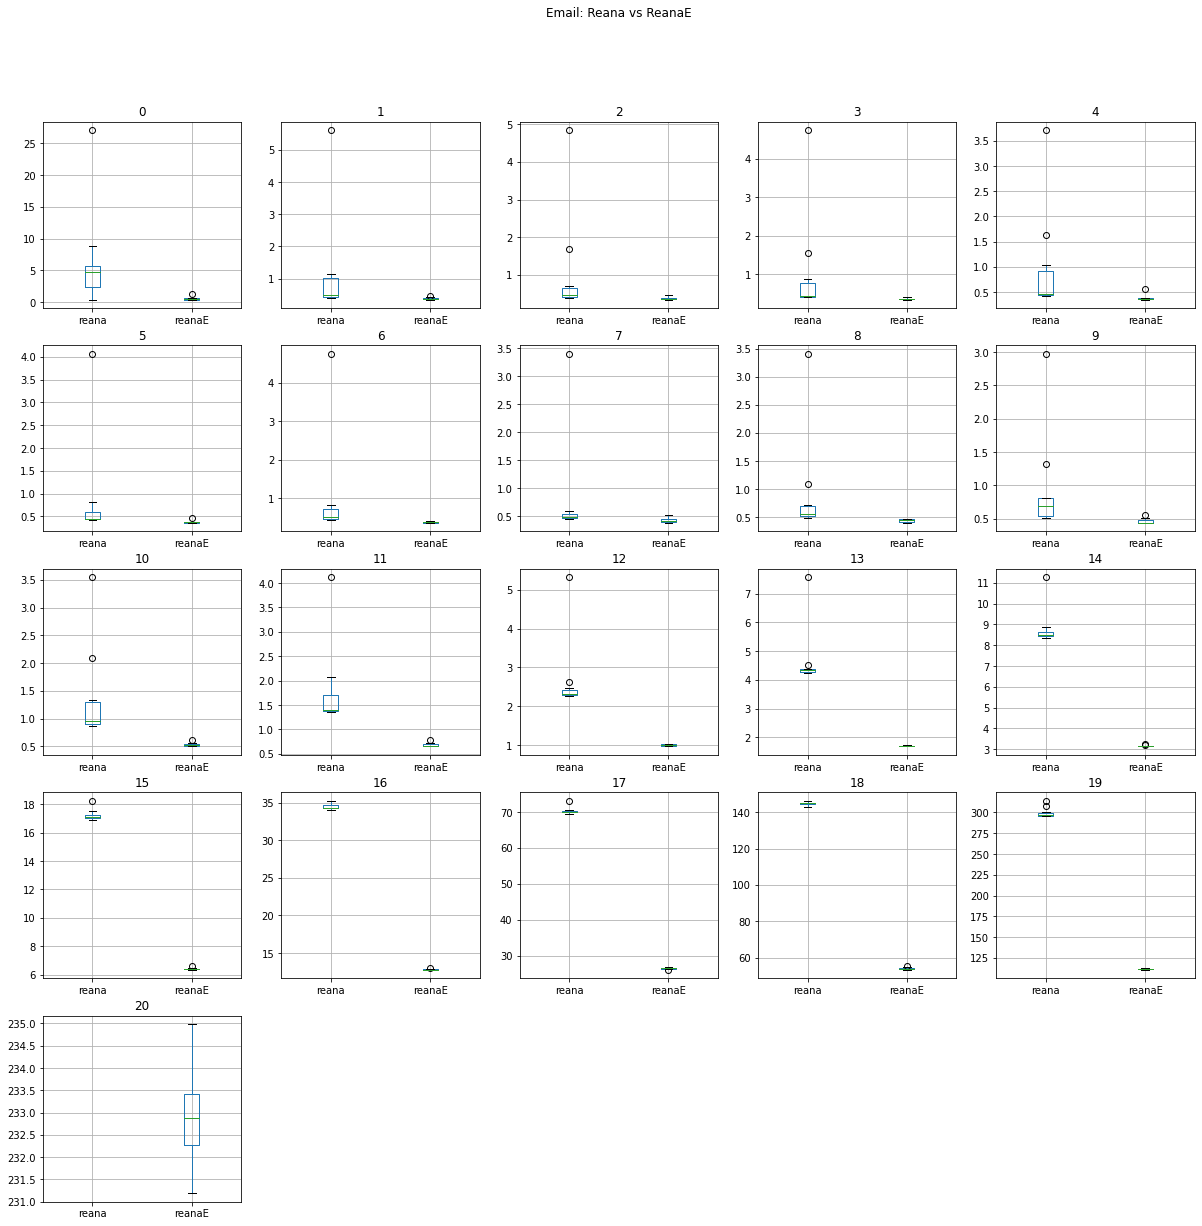

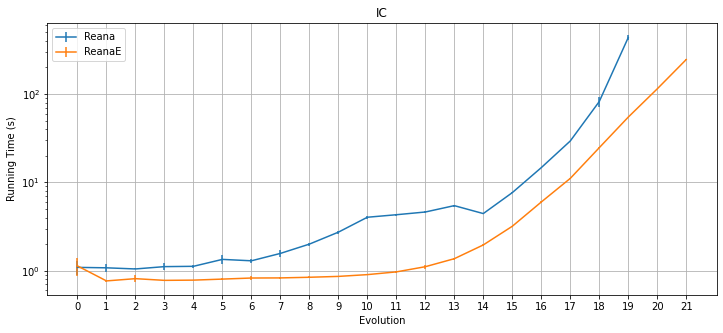

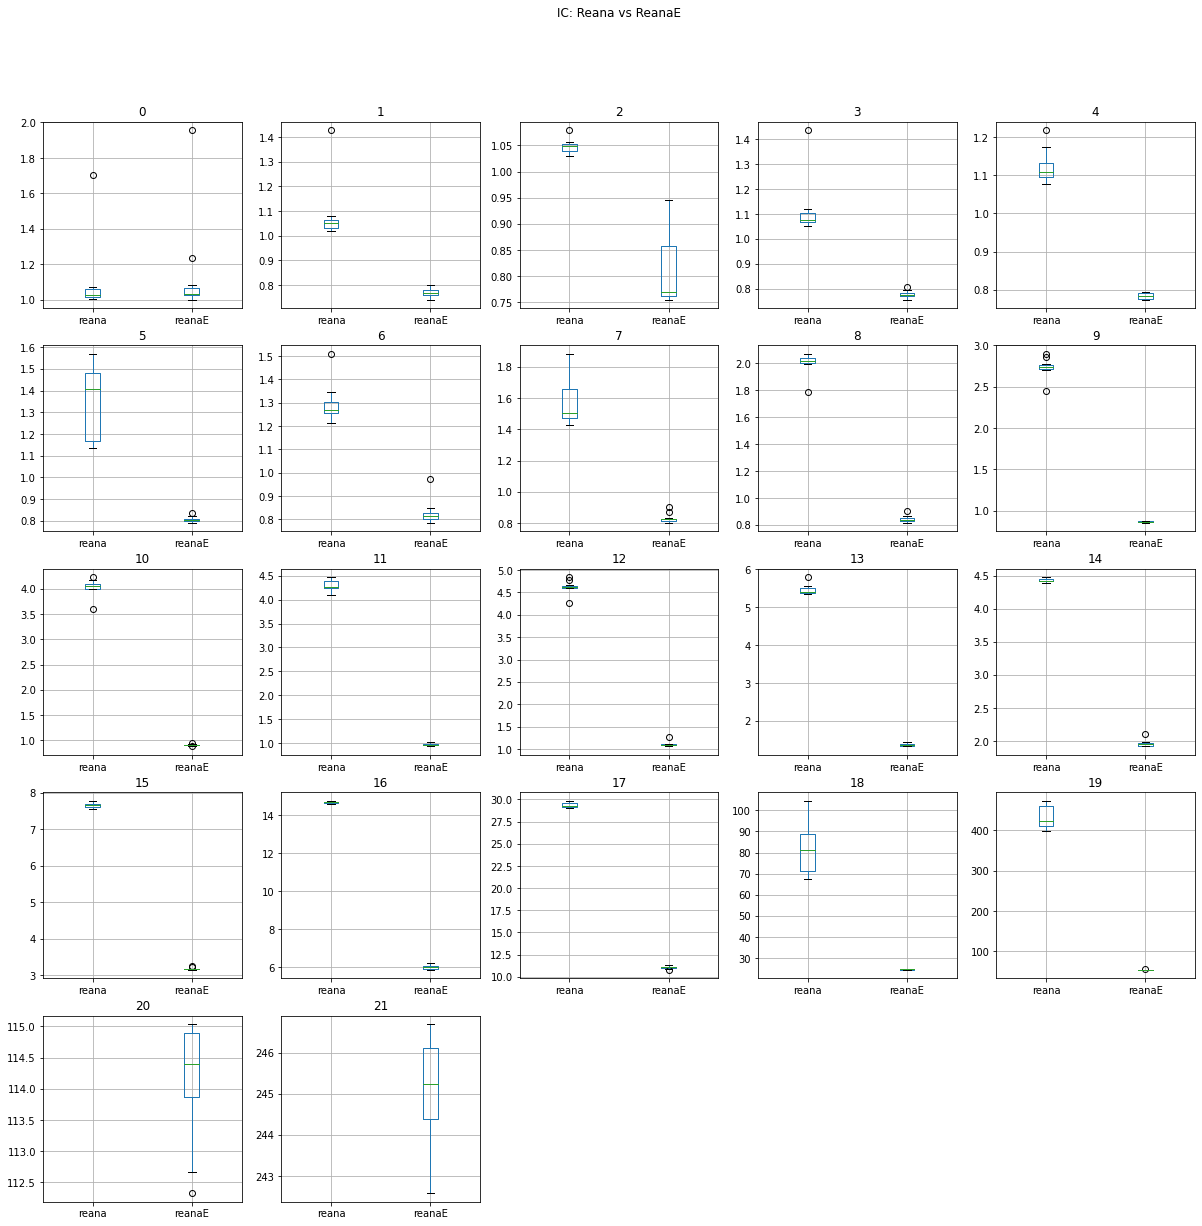

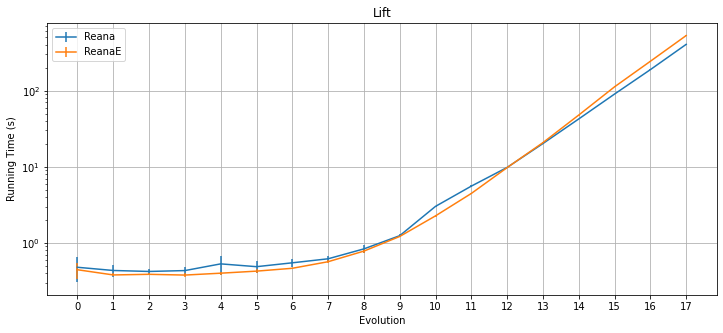

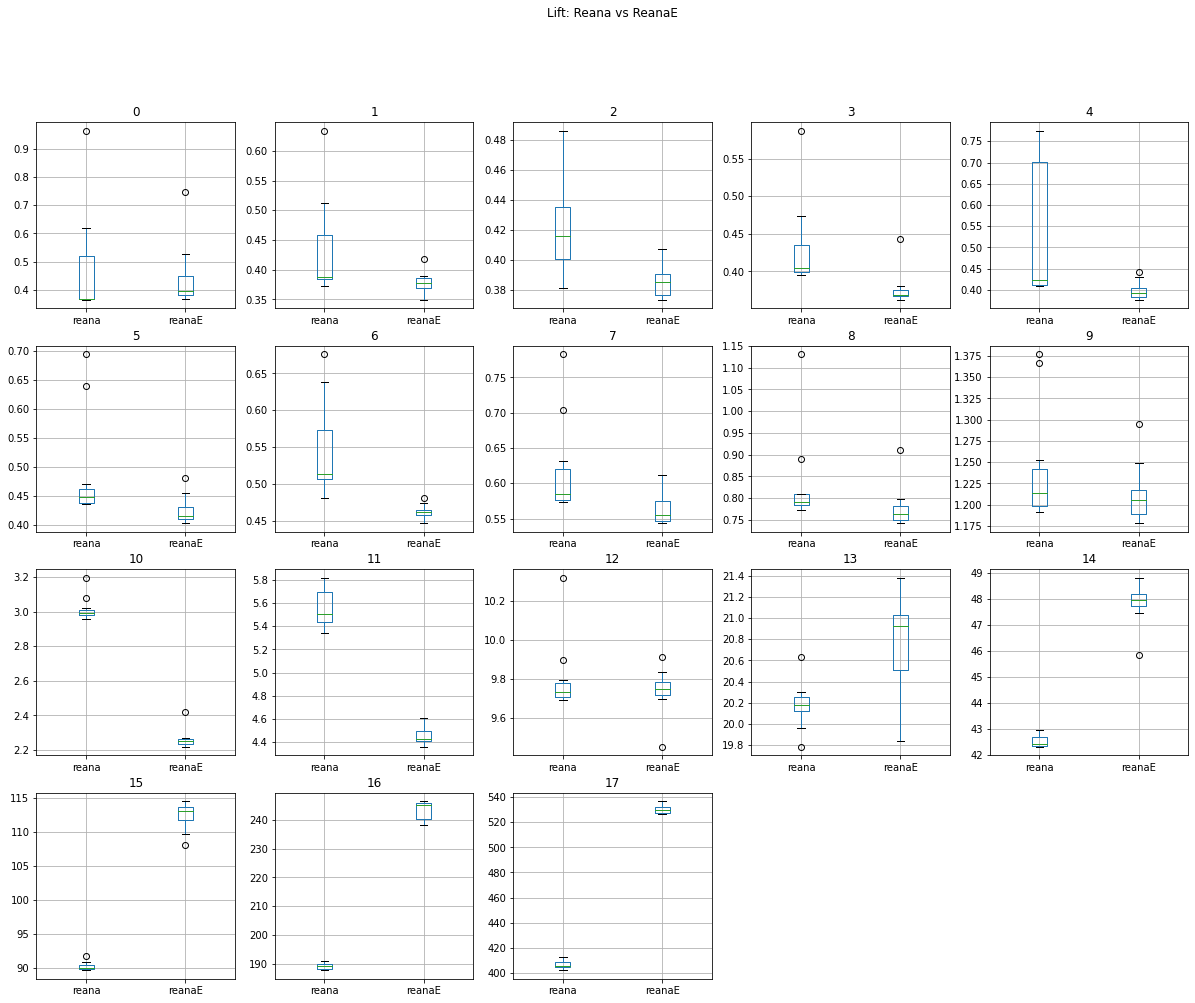

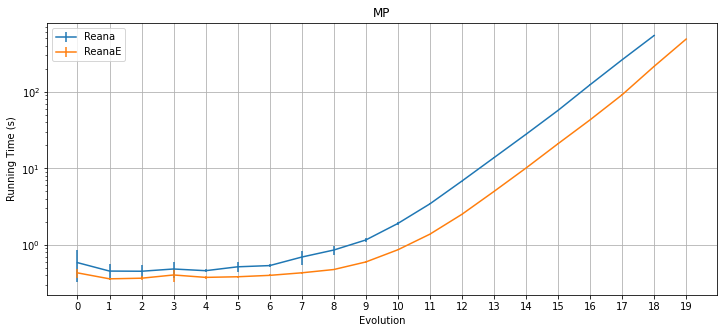

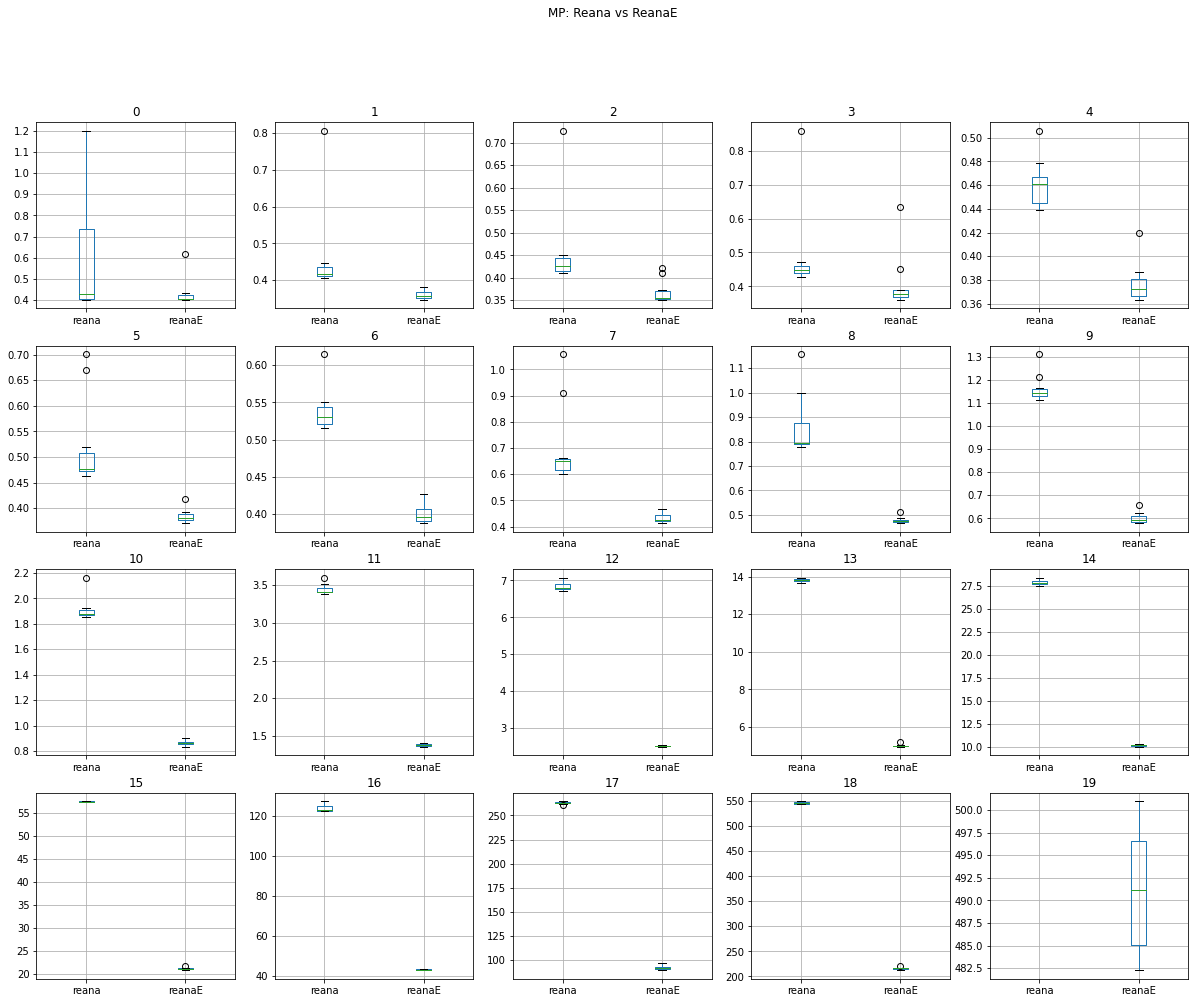

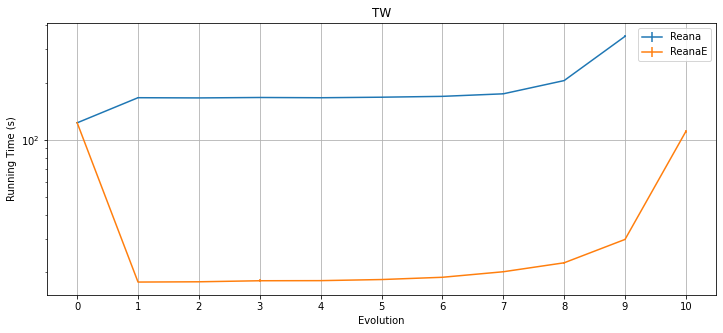

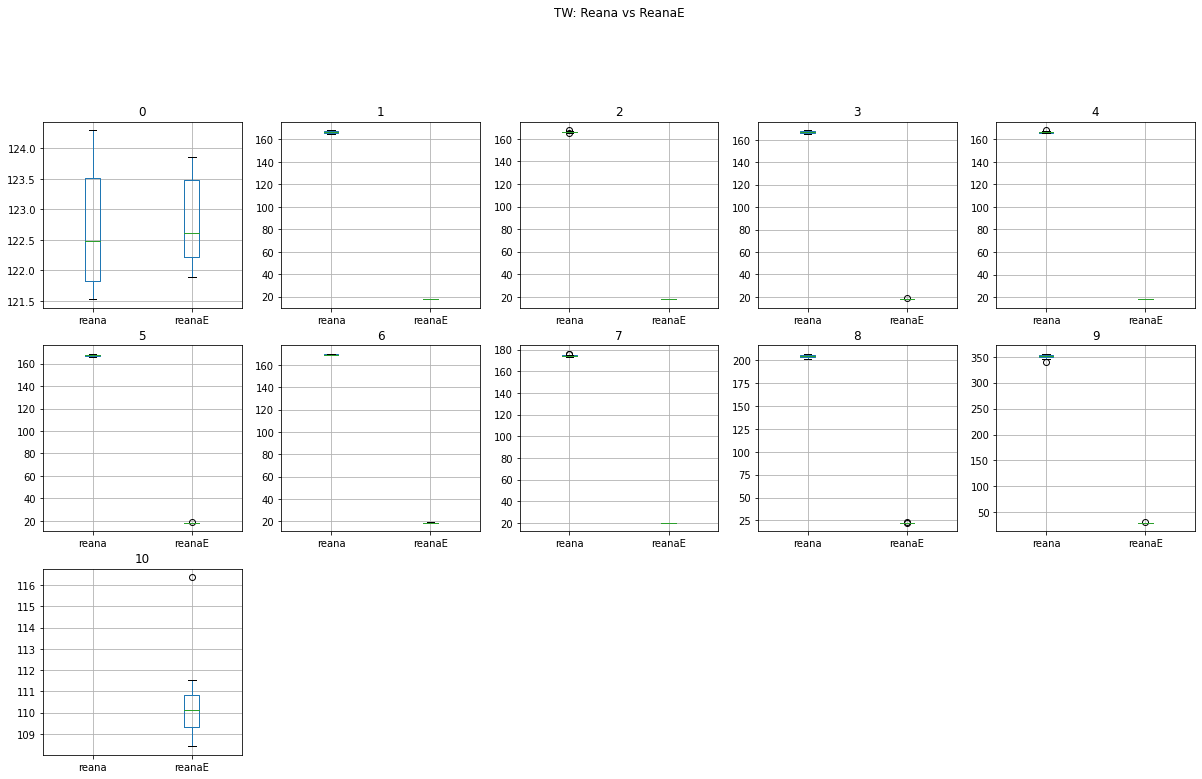

In [41]:
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']
for spl in spls:
    df = read_data(spl)
    dfe = get_extended_df(spl)
    make_line_graph(df, spl, yscale='log', filename='graphs/graph-{}.png'.format(spl))
    make_box_plot(df, spl, filename='boxplots/boxplot-{}.png'.format(spl))
    with open('tables/{}.md'.format(spl), 'w') as f:
        dfe.to_markdown(f)